In [1]:
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from typing import Set, List
nltk.download('stopwords')
import string
from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

[nltk_data] Downloading package stopwords to /home/lab744/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
sentences = []
with open('parsed_phrases.txt', 'r') as file:
  for line in file:
    sentences.append(line.replace('\n', ''))
phrase_set = set()
with open('phrases.txt', 'r') as file:
  for line in file:
    phrase_set.add(line.replace('\n', ''))

In [3]:
class CustomTokenizer:
    def __init__(self, phrase_set):

        self.phrase_set = phrase_set
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()

    def tokenize(self, sentences):
        tokenized_results = []
        for sentence in tqdm(sentences):
            sentence = sentence.strip()
            process_tokens = []
            tokens = sentence.split(' ')
            for token in tokens:
                if token in self.phrase_set:
                    process_tokens.append(token)
                    continue
                if token not in self.stop_words:
                    process_tokens.append(self.stemmer.stem(token.lower()))
                                          
            if process_tokens:
                tokenized_results.append(process_tokens)
        return tokenized_results
                
                    
                    


In [4]:
tokenizer = CustomTokenizer(phrase_set)

In [5]:
tokenized_results = tokenizer.tokenize(sentences)

100%|███████████████████████████████████████████████████████████████████████| 3302964/3302964 [06:14<00:00, 8821.18it/s]


In [6]:
def train_word2vec(processed_sentences, vector_size=100, window = 5, min_count = 1):
    model = Word2Vec(
        sentences = processed_sentences,
        vector_size = vector_size,
        window = window,
        min_count = min_count,
        workers = 4
    )
    return model

In [7]:
model = train_word2vec(tokenized_results)

In [8]:
phrases = list(phrase_set)

In [9]:
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture

In [10]:
class PhraseDataset(Dataset):
    def __init__(self, vectors):
        self.vectors = vectors
    
    def __len__(self):
        return len(self.vectors)
    
    def __getitem__(self, idx):
        return self.vectors[idx]

In [11]:
class PhraseClusterer:
    def __init__(self, w2v_model=None, batch_size=1024):
        if w2v_model:
            self.model = w2v_model
        self.clusterer = None
        self.phrase_vectors = None
        self.phrases = None
        self.batch_size = batch_size
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        if self.device.type == "cuda":
            print(f"GPU: {torch.cuda.get_device_name()}")

    def get_phrase_vec(self, phrase):
        try:
            return self.model.wv[phrase]
        except KeyError:
            print("No phrase embedding in Word2Vec model: ", phrase)
            return None

    def prep_vecs(self, phrases):
        self.phrases = phrases
        vectors = []
        
        for i in range(0, len(phrases), self.batch_size):
            batch = phrases[i:i + self.batch_size]
            batch_vectors = [self.get_phrase_vec(phrase) for phrase in batch]
            batch_vectors = [v for v in batch_vectors if v is not None]
            vectors.extend(batch_vectors)
        
        self.phrase_vectors = np.array(vectors)
        vectors = np.array(vectors)
        self.torch_vectors = torch.tensor(vectors, dtype=torch.float32).to(self.device)

    class CUDAKMeans:
        def __init__(self, n_clusters, max_iter=100, device='cuda'):
            self.n_clusters = n_clusters
            self.max_iter = max_iter
            self.device = device
            self.cluster_centers_ = None
            self.labels_ = None
            self.inertia_ = None

        def fit_predict(self, X_tensor):
            n_samples = X_tensor.shape[0]
            

            idx = torch.randperm(n_samples, device=self.device)[:self.n_clusters]
            self.cluster_centers_ = X_tensor[idx].clone()
            
            prev_labels = None
            
            for _ in range(self.max_iter):
                distances = torch.cdist(X_tensor, self.cluster_centers_)
                new_labels = torch.argmin(distances, dim=1)
                
                if prev_labels is not None and torch.equal(new_labels, prev_labels):
                    break
                
                prev_labels = new_labels.clone()
                
                for k in range(self.n_clusters):
                    mask = new_labels == k
                    if torch.any(mask):
                        self.cluster_centers_[k] = X_tensor[mask].mean(0)
            
            self.labels_ = new_labels
            min_distances = torch.min(distances, dim=1).values
            self.inertia_ = torch.sum(min_distances ** 2)
            
            return self.labels_.cpu().numpy()

    class CUDAGMM:
        def __init__(self, n_components, max_iter=100, tol=1e-3, device='cuda'):
            self.n_components = n_components
            self.max_iter = max_iter
            self.tol = tol
            self.device = device
            self.weights_ = None
            self.means_ = None
            self.covs_ = None
            self.labels_ = None

        def _init_params(self, X):
            n_samples, n_features = X.shape

            idx = torch.randint(0, n_samples, (1,), device=self.device)
            means = [X[idx]]
            
            for _ in range(1, self.n_components):
                distances = torch.min(torch.stack([torch.sum((X - mean) ** 2, dim=1) 
                                                for mean in means]), dim=0)[0]

                probs = distances / torch.sum(distances)
                idx = torch.multinomial(probs, 1)
                means.append(X[idx])
            
            self.means_ = torch.stack(means).squeeze()
            
            self.weights_ = torch.ones(self.n_components, device=self.device) / self.n_components
            
            self.covs_ = torch.stack([torch.eye(n_features, device=self.device) 
                                    for _ in range(self.n_components)])

        def _e_step(self, X):
            n_samples = X.shape[0]
            resp = torch.zeros((n_samples, self.n_components), device=self.device)
            
            for k in range(self.n_components):
                diff = X - self.means_[k]
                precision = torch.inverse(self.covs_[k])
                log_det = torch.logdet(self.covs_[k])
                
                # Compute log probability for each sample
                mahalanobis = torch.sum((diff @ precision) * diff, dim=1)
                resp[:, k] = -0.5 * (mahalanobis + log_det) + torch.log(self.weights_[k])
            
            # Normalize responsibilities
            log_resp = resp - torch.logsumexp(resp, dim=1, keepdim=True)
            resp = torch.exp(log_resp)
            
            return resp

        def _m_step(self, X, resp):
            n_samples = X.shape[0]
            
            nk = torch.sum(resp, dim=0)
            self.weights_ = nk / n_samples
            
            self.means_ = (resp.T @ X) / nk.unsqueeze(1)
            
            for k in range(self.n_components):
                diff = X - self.means_[k]
                self.covs_[k] = (diff.T @ (resp[:, k:k+1] * diff)) / nk[k]
                self.covs_[k] += torch.eye(X.shape[1], device=self.device) * 1e-6

        def fit_predict(self, X_tensor):
            self._init_params(X_tensor)
            
            prev_log_likelihood = None
            
            for _ in range(self.max_iter):
                resp = self._e_step(X_tensor)
                
                self._m_step(X_tensor, resp)
                
                log_likelihood = torch.mean(torch.logsumexp(self._e_step(X_tensor), dim=1))
                if prev_log_likelihood is not None:
                    if abs(log_likelihood - prev_log_likelihood) < self.tol:
                        break
                prev_log_likelihood = log_likelihood
            
            self.labels_ = torch.argmax(resp, dim=1)
            return self.labels_.cpu().numpy()
            
    class MemoryEfficientHAC:
        def __init__(self, n_clusters, max_samples=10000, linkage='ward', random_state=42):
            self.n_clusters = n_clusters
            self.max_samples = max_samples
            self.linkage_method = linkage
            self.random_state = random_state
            self.labels_ = None
            self.children_ = None
            self.linkage_matrix_ = None 
            
        def fit_predict(self, X):
            n_samples = X.shape[0]
            
            if n_samples > self.max_samples:
                print(f"Warning: Dataset size ({n_samples}) exceeds max_samples ({self.max_samples})")
                print("Using random subsampling for HAC")
                
                np.random.seed(self.random_state)
                subsample_idx = np.random.choice(n_samples, self.max_samples, replace=False)
                X_subsample = X[subsample_idx]
                
                self.linkage_matrix_ = linkage(X_subsample, method=self.linkage_method)
                
                clusterer = AgglomerativeClustering(
                    n_clusters=self.n_clusters,
                    linkage=self.linkage_method
                )
                subsample_labels = clusterer.fit_predict(X_subsample)
                
                if self.linkage_method == 'ward':
                    centers = np.array([
                        X_subsample[subsample_labels == i].mean(axis=0)
                        for i in range(self.n_clusters)
                    ])
                    
                    self.labels_ = np.zeros(n_samples, dtype=int)
                    self.labels_[subsample_idx] = subsample_labels
                    
                    remaining_idx = np.setdiff1d(np.arange(n_samples), subsample_idx)
                    batch_size = 10000
                    
                    for i in range(0, len(remaining_idx), batch_size):
                        batch_idx = remaining_idx[i:i + batch_size]
                        batch_data = X[batch_idx]
                        distances = np.array([
                            np.sum((batch_data - center) ** 2, axis=1)
                            for center in centers
                        ])
                        self.labels_[batch_idx] = distances.argmin(axis=0)
                else:
                    self.labels_ = np.zeros(n_samples, dtype=int)
                    self.labels_[subsample_idx] = subsample_labels
                    
                    remaining_idx = np.setdiff1d(np.arange(n_samples), subsample_idx)
                    batch_size = 10000
                    
                    for i in range(0, len(remaining_idx), batch_size):
                        batch_idx = remaining_idx[i:i + batch_size]
                        batch_data = X[batch_idx]
                        min_distances = np.inf * np.ones((len(batch_idx), self.n_clusters))
                        
                        for j in range(self.n_clusters):
                            cluster_points = X_subsample[subsample_labels == j]
                            for k in range(0, len(cluster_points), batch_size):
                                cluster_batch = cluster_points[k:k + batch_size]
                                dist_matrix = cdist(batch_data, cluster_batch)
                                min_distances[:, j] = np.minimum(
                                    min_distances[:, j],
                                    dist_matrix.min(axis=1)
                                )
                        
                        self.labels_[batch_idx] = min_distances.argmin(axis=1)
            
            else:
                self.linkage_matrix_ = linkage(X, method=self.linkage_method)

                clusterer = AgglomerativeClustering(
                    n_clusters=self.n_clusters,
                    linkage=self.linkage_method
                )
                self.labels_ = clusterer.fit_predict(X)
            
            return self.labels_
            
    def cluster_phrases(self, n_clusters=6, method='kmeans', max_hac_samples=10000):
        if self.phrase_vectors is None:
            raise ValueError("No phrase vectors")

        results = {}
        
        if method.lower() == 'kmeans':
            if torch.cuda.is_available():
                print(f"Using CUDA KMeans on {torch.cuda.get_device_name()}")
                self.clusterer = self.CUDAKMeans(n_clusters=n_clusters, device=self.device)
                labels = self.clusterer.fit_predict(self.torch_vectors)
                
                results = {
                    'labels': labels,
                    'cluster_centers': self.clusterer.cluster_centers_.cpu().numpy(),
                    'inertia': float(self.clusterer.inertia_.cpu().numpy())
                }
            else:
                print("CUDA not available, using CPU MiniBatchKMeans")
                self.clusterer = MiniBatchKMeans(n_clusters=n_clusters,
                                               batch_size=self.batch_size,
                                               random_state=42)
                labels = self.clusterer.fit_predict(self.phrase_vectors)
                results = {
                    'labels': labels,
                    'cluster_centers': self.clusterer.cluster_centers_,
                    'inertia': float(self.clusterer.inertia_)
                }
        
        elif method.lower() == 'gmm':
            if torch.cuda.is_available():
                print(f"Using CUDA GMM on {torch.cuda.get_device_name()}")
                self.clusterer = self.CUDAGMM(n_components=n_clusters, device=self.device)
                labels = self.clusterer.fit_predict(self.torch_vectors)
                
                results = {
                    'labels': labels,
                    'means': self.clusterer.means_.cpu().numpy(),
                    'covariances': self.clusterer.covs_.cpu().numpy(),
                    'weights': self.clusterer.weights_.cpu().numpy()
                }
            else:
                print("CUDA not available, using CPU GMM")
                
                self.clusterer = GaussianMixture(n_components=n_clusters, random_state=42)
                labels = self.clusterer.fit_predict(self.phrase_vectors)
                
                results = {
                    'labels': labels,
                    'means': self.clusterer.means_,
                    'covariances': self.clusterer.covariances_,
                    'weights': self.clusterer.weights_
                }
        
        elif method.lower() == 'hac':
            print(f"Using Memory-Efficient HAC (max samples: {max_hac_samples})")
            self.clusterer = self.MemoryEfficientHAC(
                n_clusters=n_clusters,
                max_samples=max_hac_samples,
                linkage='ward'
            )
            labels = self.clusterer.fit_predict(self.phrase_vectors)
            
            results = {
                'labels': labels,
                'children': self.clusterer.children_ if hasattr(self.clusterer, 'children_') else None
            }
        
        else:
            raise ValueError(f"Unknown clustering method: {method}")
    
        cpu_vectors = self.phrase_vectors
        sample_size = min(10000, len(cpu_vectors))
        sample_idx = np.random.choice(len(cpu_vectors), sample_size, replace=False)
        
        results.update({
            'silhouette_score': float(silhouette_score(
                cpu_vectors[sample_idx], 
                results['labels'][sample_idx]
            )),
            'db_score': float(davies_bouldin_score(cpu_vectors, results['labels']))
        })
        
        return results

    def get_cluster_phrases(self, labels):
        cluster_phrases = {}
        for phrase, label in zip(self.phrases, labels):
            if label not in cluster_phrases:
                cluster_phrases[label] = []
            cluster_phrases[label].append(phrase)
        return cluster_phrases

    def visualize_clusters(self, labels, method='pca', max_display_samples=1000):
        
        if method.lower() == 'pca':
            vectors_for_vis = self.phrase_vectors

            pca = PCA(n_components=2)
            reduced_vectors = pca.fit_transform(vectors_for_vis)
    
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1],
                                c=labels, cmap='viridis')
            plt.colorbar(scatter)
            plt.title('Phrase Clusters Visualization (PCA)')
            plt.xlabel('First Principal Component')
            plt.ylabel('Second Principal Component')
            
        elif method.lower() == 'dendrogram':
            if not hasattr(self.clusterer, 'linkage_matrix_'):
                print("Linkage matrix not available. ")
                

                n_samples = len(self.phrase_vectors)
                if n_samples > max_display_samples:
                    np.random.seed(42)
                    idx = np.random.choice(n_samples, max_display_samples, replace=False)
                    sample_data = self.phrase_vectors[idx]
                else:
                    sample_data = self.phrase_vectors
                

                scaler = StandardScaler()
                sample_data_scaled = scaler.fit_transform(sample_data)
                

                linkage_matrix = linkage(sample_data_scaled, method='ward')
            else:
                linkage_matrix = self.clusterer.linkage_matrix_
            

            plt.figure(figsize=(12, 8))
            dendrogram(
                linkage_matrix,
                truncate_mode='lastp', 
                p=30,  
                show_leaf_counts=True,
                leaf_rotation=90.,
                leaf_font_size=12.,
                show_contracted=True
            )
            plt.title('Hierarchical Clustering Dendrogram (Truncated)')
            plt.xlabel('Sample index or (cluster size)')
            plt.ylabel('Distance')
        
        plt.tight_layout()
        plt.savefig('results.png')
        plt.show()
        

In [21]:
clusterer = PhraseClusterer(model)

Using device: cuda
GPU: NVIDIA GeForce RTX 3070


In [22]:
clusterer.prep_vecs(phrases)

No phrase embedding in Word2Vec model:  STBC MIMO
No phrase embedding in Word2Vec model:   - 
No phrase embedding in Word2Vec model:  image_omitted]_ 
No phrase embedding in Word2Vec model:   < 
No phrase embedding in Word2Vec model:    
No phrase embedding in Word2Vec model:   = 
No phrase embedding in Word2Vec model:  image_omitted] 
No phrase embedding in Word2Vec model:  Mac OS


In [23]:
kmeans_results = clusterer.cluster_phrases(n_clusters=6, method='kmeans')
print("kmeans_finished")
gmm_results = clusterer.cluster_phrases(n_clusters=6, method='gmm')
print("gmm_finished")
hac_results = clusterer.cluster_phrases(n_clusters=6, method='hac')
print("hac_finished")

Using CUDA KMeans on NVIDIA GeForce RTX 3070
kmeans_finished
Using CUDA GMM on NVIDIA GeForce RTX 3070
gmm_finished
Using Memory-Efficient HAC (max samples: 10000)
Using random subsampling for HAC
hac_finished


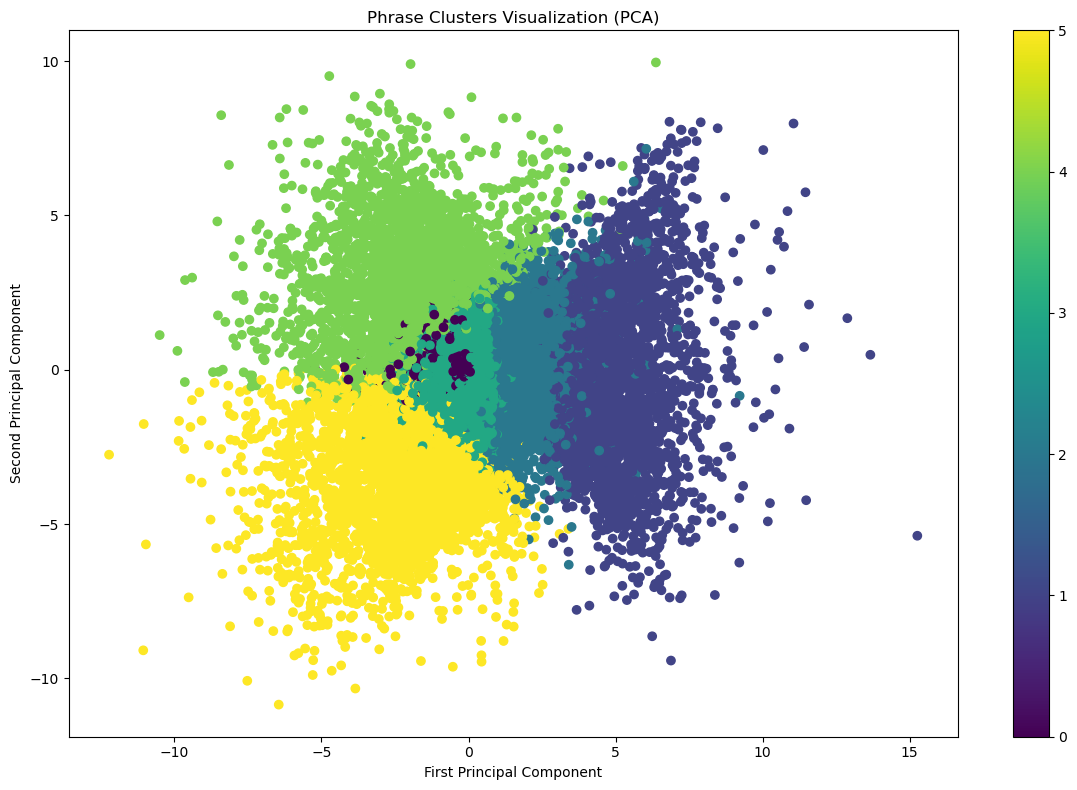

In [35]:
clusterer.visualize_clusters(kmeans_results['labels'], method='pca')
#clusterer.visualize_clusters(gmm_results['labels'], method='pca')
#clusterer.visualize_clusters(hac_results['labels'], method='pca')

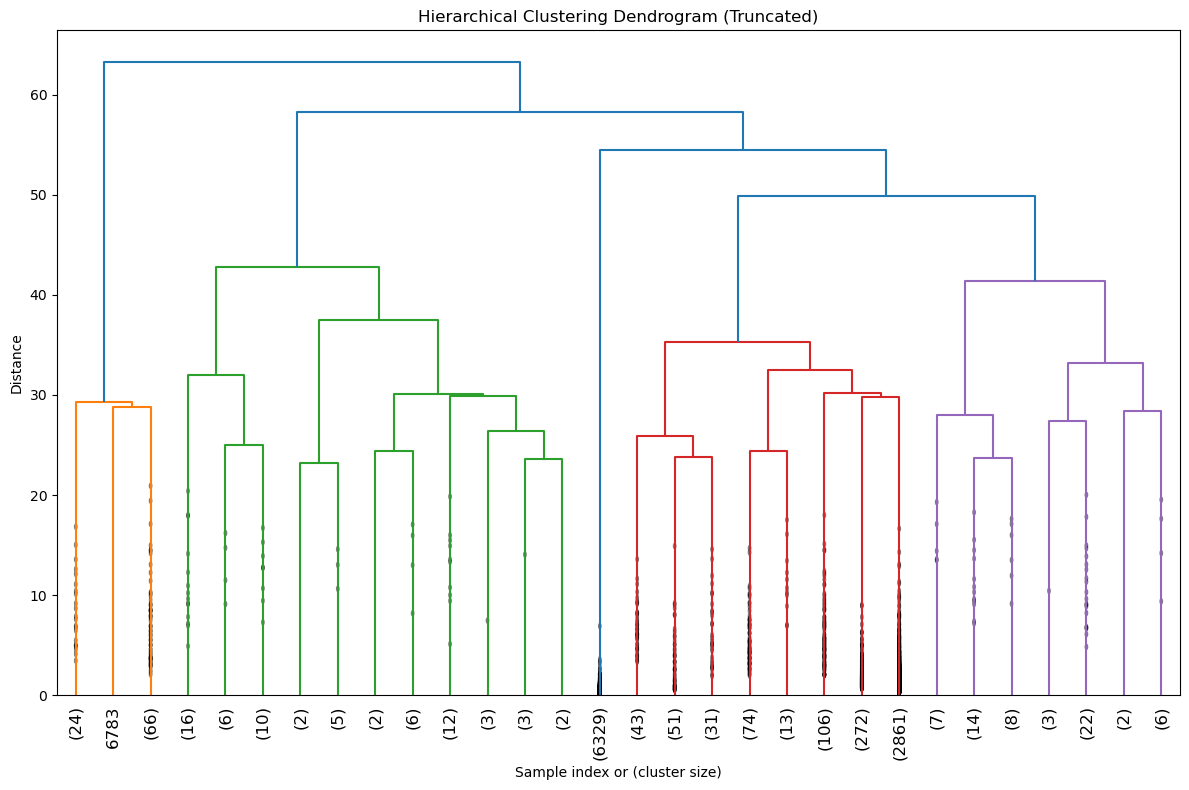

In [36]:
clusterer.visualize_clusters(hac_results['labels'], method='dendrogram')

In [24]:
kmeans_phrases = clusterer.get_cluster_phrases(kmeans_results['labels'])
gmm_phrases = clusterer.get_cluster_phrases(gmm_results['labels'])
hac_phrases = clusterer.get_cluster_phrases(hac_results['labels'])

In [25]:
for key, value in kmeans_phrases.items():
    print(key)
    print(value[:20])

4
['sharpness', 'word-level', 'Markovian', 'cyclic', '&rho', 'angular', 'precedence', 'data_stream', 'MSE', 'domain_decomposition', 'prior_information', 'slip', 'non-overlapping', 'unit_interval', 'd', 'Gn', 'redistribution', 'multiple_paths', 'color_space', 'PDE']
1
['Cramer-Rao-Lower-Bound', 'Constructive_Meta-Learning', 'Gaussian_Particle_Swarm', 'Chronic_diseases', 'Incremental_Deployment', "Today's_SoC", 'Single-Valued', 'Sleep_deprivation', 'Cambridge_University_press', 'asymmetric_group_key_agreement', 'Key_Parameters', 'Tarjan_Algorithm', 'Control-Data', 'gray_level_image', 'age-replacement_policy', 'inverse_modeling', 'polar-coordinate', 'dual-arm_cluster_tools', 'shamanic', 'design_problem']
0
['du_langage', 'Moving_Obstacles', 'heterogeneous_database_integration', 'Predicate_Transformer', 'image_hiding', 'PCFG', 'Experience_Based', 'Kawasaki', 'busy_period', 'Coarse-Grained_Reconfigurable_Array', 'social_action', 'rotation-based', 'regular_and_context-free_languages', 'close

In [26]:
for key, value in gmm_phrases.items():
    print(key)
    print(value[:20])

5
['sharpness', 'busy_period', 'oblivious_transfer', 'step_by_step', 'word-level', 'AMC', 'inversely_proportional_to', 'angular', 'ASIC', 'data_stream', 'MSE', 'domain_decomposition', 'slow_down', 'prior_information', 'non-overlapping', 'network_parameters', 'Gn', 'user_specified', 'redistribution', 'too_expensive']
0
['Cramer-Rao-Lower-Bound', 'Constructive_Meta-Learning', 'du_langage', 'Gaussian_Particle_Swarm', 'Moving_Obstacles', 'Chronic_diseases', 'Incremental_Deployment', "Today's_SoC", 'Single-Valued', 'Sleep_deprivation', 'heterogeneous_database_integration', 'Cambridge_University_press', 'Predicate_Transformer', 'asymmetric_group_key_agreement', 'Key_Parameters', 'Tarjan_Algorithm', 'Control-Data', 'image_hiding', 'Experience_Based', 'gray_level_image']
2
['Accessibility', 'Service_Level_Agreement', 'Jordan', 'Kommunikation', 'Resilient', 'route_optimization', 'namespace', 'decision_analysis', 'miRNA', 'Evolutionary', 'Secret_Key', 'annotating', 'Subgroup', 'SDL', 'Wireless_S

In [27]:
for key, value in hac_phrases.items():
    print(key)
    print(value[:20])

0
['sharpness', '&epsiv', 'PCFG', 'busy_period', 'image_pairs', 'multigraphs', 'word-level', 'Markovian', 'cyclic', 'miRNA', 'nearest_neighbor_search', '&rho', 'inversely_proportional_to', 'angular', 'precedence', 'UKF', 'MSE', 'semi-infinite', 'domain_decomposition', 'prior_information']
3
['Cramer-Rao-Lower-Bound', 'Constructive_Meta-Learning', 'Gaussian_Particle_Swarm', 'Chronic_diseases', 'Incremental_Deployment', "Today's_SoC", 'Single-Valued', 'Sleep_deprivation', 'Cambridge_University_press', 'asymmetric_group_key_agreement', 'Key_Parameters', 'Tarjan_Algorithm', 'Control-Data', 'gray_level_image', 'age-replacement_policy', 'inverse_modeling', 'polar-coordinate', 'dual-arm_cluster_tools', 'shamanic', 'design_problem']
4
['du_langage', 'Moving_Obstacles', 'heterogeneous_database_integration', 'Predicate_Transformer', 'image_hiding', 'Experience_Based', 'Splatting', 'Service_Level_Agreement', 'Dictation', 'Coarse-Grained_Reconfigurable_Array', 'social_action', 'rotation-based', 'r

In [33]:
print(kmeans_results['silhouette_score'])
print(kmeans_results['db_score'])

0.3822171688079834
2.9118127555887963


In [34]:
print(gmm_results['silhouette_score'])
print(gmm_results['db_score'])

0.6547107696533203
5.03433796164548


In [35]:
print(hac_results['silhouette_score'])
print(hac_results['db_score'])

0.4262920022010803
2.9714840735382224
